# Imports

In [1]:
# @title
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Data

In [2]:
# @title
url = "https://raw.githubusercontent.com/sinc-lab/ET-Pfam/master/results/predictions_singleDL.csv"
pred_DL =  pd.read_csv(url, sep=';')
url = "https://raw.githubusercontent.com/sinc-lab/ET-Pfam/master/results/predictions_ensembleET.csv"
pred_ET =  pd.read_csv(url, sep=';')
url = "https://raw.githubusercontent.com/sinc-lab/ET-Pfam/master/results/predictions_blastp.csv"
pred_blast =  pd.read_csv(url, sep=',')
url = "https://raw.githubusercontent.com/sinc-lab/ET-Pfam/master/results/predictions_hmm.csv"
pred_hmm =  pd.read_csv(url, sep=',')
url = "https://raw.githubusercontent.com/sinc-lab/ET-Pfam/master/results/predictions_protenn.csv"
pred_protenn =  pd.read_csv(url, sep=';')
url = "https://raw.githubusercontent.com/sinc-lab/ET-Pfam/master/results/test_ref.csv"
test =  pd.read_csv(url, sep=',', index_col=0)

# Calculate error rates

In [3]:
# @title
# sorting families by the number of cases in test set
def sort_by_size(df, counts):
  df_merged = pd.merge(df, counts, on='PF', how='right')
  df_ordered = df_merged.sort_values(by='count')
  return df_ordered
test_counts = test.groupby(['PF']).size().reset_index(name='count')
test_labels = test.PF.unique()
test_counts_ordered = test_counts.copy().set_index('PF').reindex(test_labels)

In [4]:
# @title
y1 = pred_DL['PF']
y2 = pred_DL['pred_coverage']
err_12 = 1-recall_score(y1, y2, average=None, labels=test_labels)

y1 = pred_ET['PF']
y2 = pred_ET['pred_coverage']
err_7 = 1-recall_score(y1, y2, average=None, labels=test_labels)

y1 = pred_blast['PF']
y2 = pred_blast['pred_blast']
err_blast = 1-recall_score(y1, y2, average=None, labels=test_labels)

y1 = pred_hmm['PF']
y2 = pred_hmm['pred']
err_hmm = 1-recall_score(y1, y2, average=None, labels=test_labels)

y1 = pred_protenn['PF']
y2 = pred_protenn['pred_ensamble']
err_protenn = 1-recall_score(y1, y2, average=None, labels=test_labels)

In [5]:
# @title
column_names = ['PF', 'num_test','modelDL', 'modelET', 'blast', 'hmm', 'protenn']
data = pd.DataFrame([test_labels, test_counts_ordered['count'], err_12, err_7, err_blast, err_hmm, err_protenn]).T
data.columns = column_names
data.set_index('PF', inplace=True)
data.to_csv('Per-family_errors.csv')

# Compare the error distributions of two models


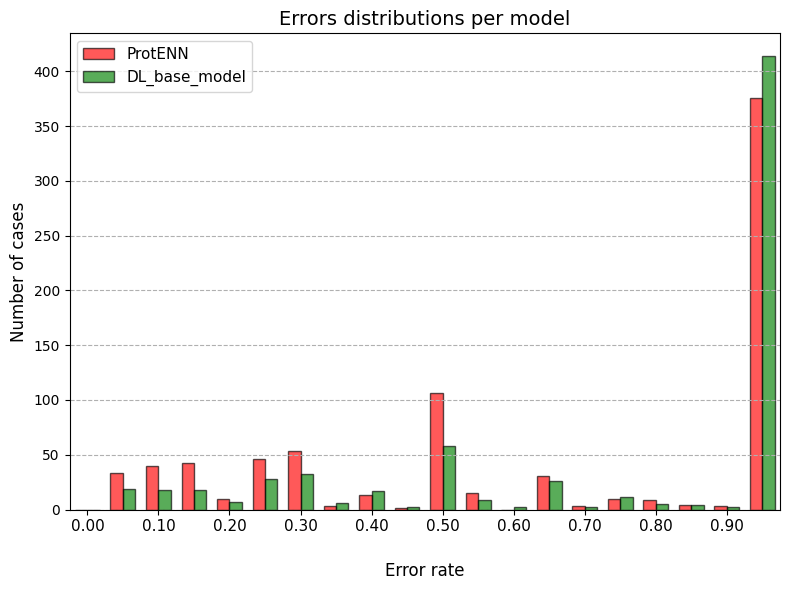

In [6]:
#@title Select models { run: "auto" }
#@markdown
model1 = 'ProtENN' #@param ['HMM','Blastp','ProtENN','DL_base_model','ET-Pfam']
model2 = "DL_base_model" #@param ['HMM','Blastp','ProtENN','DL_base_model','ET-Pfam']
#@markdown ---
cut_off = 0.05
model_map = {
    'ProtENN': (data[data['protenn'] > cut_off]['protenn'], 'red'),
    'HMM': (data[data['hmm'] > cut_off]['hmm'], 'black'),
    'DL_base_model': (data[data['modelDL'] > 0.05]['modelDL'], 'green'),
    'Blastp': (data[data['blast'] > cut_off]['blast'], 'gray'),
    'ET-Pfam': (data[data['modelET'] > cut_off]['modelET'], 'yellow')
}

data1, c1 = model_map[model1]
data2, c2 = model_map[model2]

fig, ax = plt.subplots(figsize=(8, 6))

bins = np.linspace(0, 1.0, 21)
bin_width = bins[1] - bins[0]

hist_data1, _ = np.histogram(data1.astype(float), bins=bins)
hist_data2, _ = np.histogram(data2.astype(float), bins=bins)

x = np.arange(len(bins) - 1)
width = 0.35
a = 0.65

ax.bar(x - width/2, hist_data1, width, alpha=a, color=c1, label=model1, edgecolor='black', linewidth=1.0)
ax.bar(x + width/2, hist_data2, width, alpha=a, color=c2, label=model2, edgecolor='black', linewidth=1.0)
ax.grid(axis='y', linestyle='--')

ax.set_xlabel("Error rate", labelpad=20, fontsize=12)
ax.set_ylabel("Number of cases", fontsize=12)
ax.set_title("Errors distributions per model", fontsize=14)
ax.set_xticks(x[::2])
ax.set_xticklabels([f'{bins[i]:.2f}' for i in range(0, len(bins) - 1, 2)], fontsize=11)
ax.legend(fontsize=11)
ax.set_xlim(-0.5, len(x) - 0.5)
plt.tight_layout()
plt.show()

# All error distributions




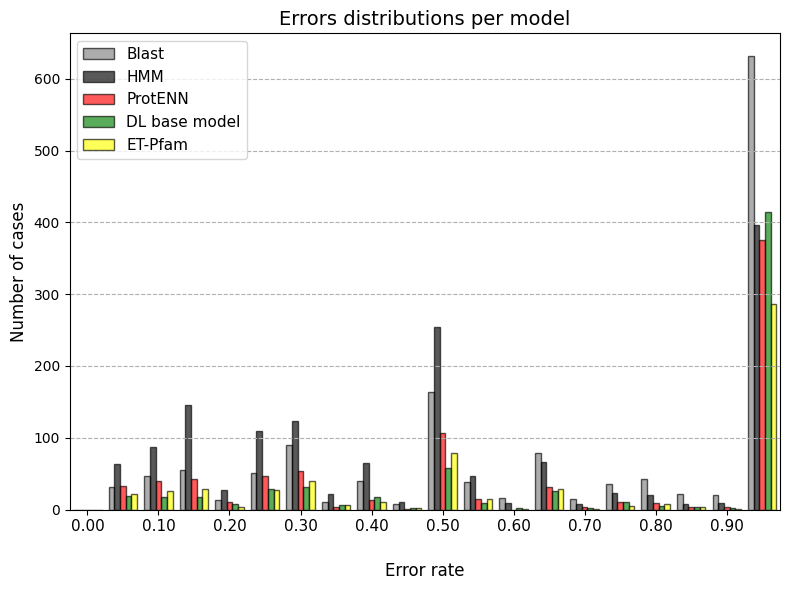

In [7]:
# @title
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.linspace(0, 1.0, 21)  # 20 bins
bin_width = bins[1] - bins[0]

hist_blast, _ = np.histogram(data[data['blast'] > 0.05]['blast'], bins=bins)
hist_hmm, _ = np.histogram(data[data['hmm']  > 0.05]['hmm'], bins=bins)
hist_protenn, _ = np.histogram(data[data['protenn'] > 0.05]['protenn'], bins=bins)
hist_dl, _ = np.histogram(data[data['modelDL'] > 0.05]['modelDL'], bins=bins)
hist_et, _ = np.histogram(data[data['modelET'] > 0.05]['modelET'], bins=bins)

x = np.arange(len(bins) - 1)
num_models = 5
width = 0.16
a = 0.65

ax.bar(x - 2*width, hist_blast, width, alpha=a, color='gray', label='Blast', edgecolor='black', linewidth=1.0)
ax.bar(x - width, hist_hmm, width, alpha=a, color='black', label='HMM', edgecolor='black', linewidth=1.0)
ax.bar(x, hist_protenn, width, alpha=a, color='red', label='ProtENN', edgecolor='black', linewidth=1.0)
ax.bar(x + width, hist_dl, width, alpha=a, color='green', label='DL base model', edgecolor='black', linewidth=1.0)
ax.bar(x + 2*width, hist_et, width, alpha=a, color='yellow', label='ET-Pfam', edgecolor='black', linewidth=1.0)
ax.grid(axis='y', linestyle='--')

ax.set_xlabel("Error rate", labelpad=20, fontsize=12)
ax.set_ylabel("Number of cases", fontsize=12)
ax.set_title("Errors distributions per model", fontsize=14)
ax.set_xticks(x[::2])
ax.set_xticklabels([f'{bins[i]:.2f}' for i in range(0, len(bins) - 1, 2)], fontsize=11)
ax.legend(fontsize=11)
ax.set_xlim(-0.5, len(x) - 0.5)
plt.tight_layout()
plt.show()